In [2]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomCrop
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc
from collections import Counter
from tensorflow.keras import backend as K
import keras_tuner




In [3]:
!pip install keras-tuner

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data_path = r'/content/drive/MyDrive/RealWaste'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),
    batch_size=32,

)


Found 4752 files belonging to 9 classes.


In [6]:
class_names = sorted(os.listdir(data_path))  # Get folder names
num_classes = len(class_names)
class_counts = np.zeros(num_classes)

In [7]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),   # Randomly flip images horizontally
    tf.keras.layers.RandomRotation(0.4),         # Randomly rotate images by up to 20%
    RandomZoom(0.4),             # Randomly zoom into images by 20%
    RandomBrightness(factor=0.4),        # Randomly increase the brightness
    RandomCrop(150,160)
])


# Apply augmentation to the training data
def augment(image, label):

    image = data_augmentation(image)
    image = tf.image.resize(image, (224, 224))
    return image , label



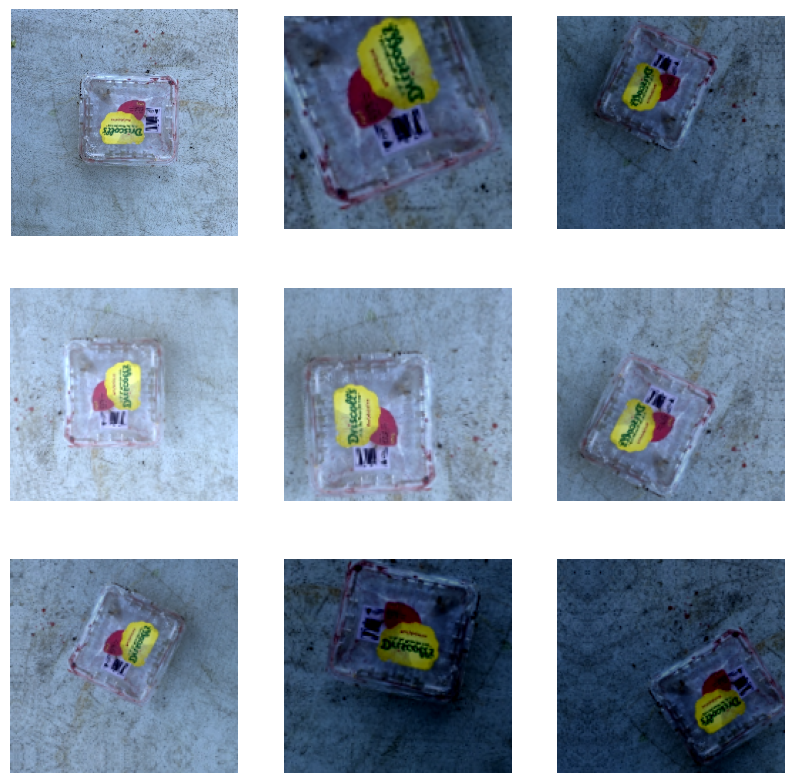

In [8]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
          image = images[0]  # Select the first image in the batch

        # Apply augmentation multiple times to the same image
    augmented_images = [image]
    for _ in range(8):  # Create 8 augmented versions
        augmented_images.append(data_augmentation(image[tf.newaxis, ...])[0])

        # Display the original and augmented images
    for i in range(9):  # Display 9 images (1 original + 8 augmented)
        ax = plt.subplot(3, 3, i + 1)
        img = augmented_images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.axis("off")

    plt.show()

# Call the function to visualize data augmentation
visualize_dataset(dataset, class_names)

In [9]:
def normalize_img(image, label):
    image = image/ 255.0  # Scale pixel values to [0, 1]
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label




In [10]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

In [11]:
train_size = int(0.7 * dataset_size)  # 70% for training
val_size = int(0.15 * dataset_size)   # 15% for validation
test_size = dataset_size - train_size - val_size  # 15% for testing

train_dataset = dataset.take(train_size).map(augment).map(normalize_img)

val_dataset = dataset.skip(train_size).take(val_size).map(normalize_img)
test_dataset = dataset.skip(train_size + val_size).map(normalize_img)

In [12]:
for images, labels in train_dataset.take(1):
    print(f"Min pixel value: {tf.reduce_min(images).numpy()}")
    print(f"Max pixel value: {tf.reduce_max(images).numpy()}")

Min pixel value: 0.0
Max pixel value: 1.0


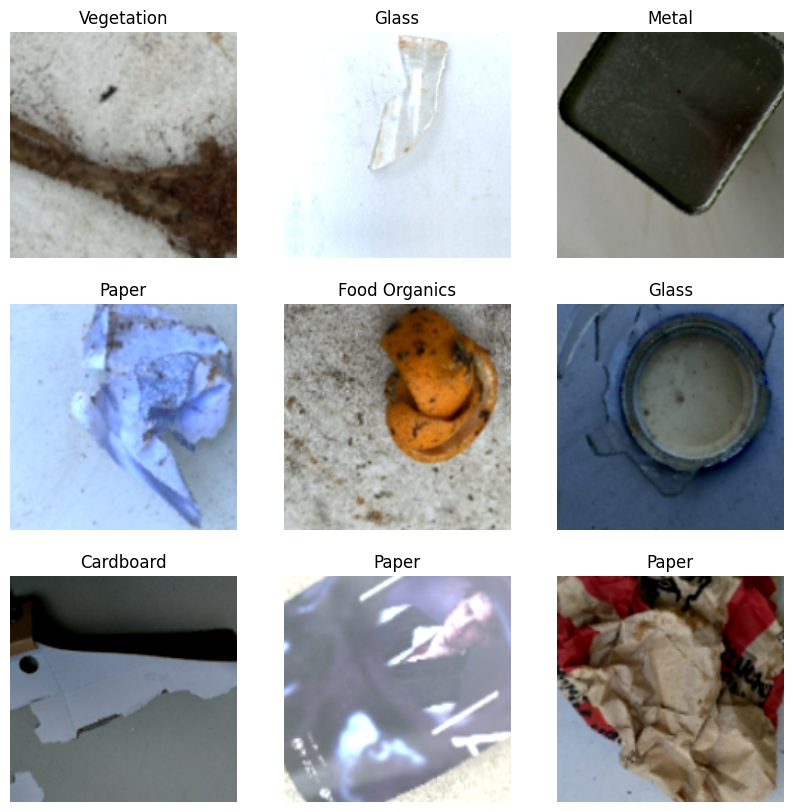

In [13]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Get one batch
        for i in range(9):  # Show 9 images
            ax = plt.subplot(3, 3, i + 1)
            img = images[i].numpy()

            # Check if the label is one-hot encoded
            if labels[i].ndim > 0:
                # Convert one-hot encoded label to scalar index
                label_idx = np.argmax(labels[i].numpy())
            else:
                # Directly use the label if it's already a scalar
                label_idx = int(labels[i].numpy())

            plt.imshow(img)
            plt.title(class_names[label_idx])
            plt.axis("off")
    plt.show()

# Visualize data augmentation results
visualize_dataset(train_dataset, class_names)


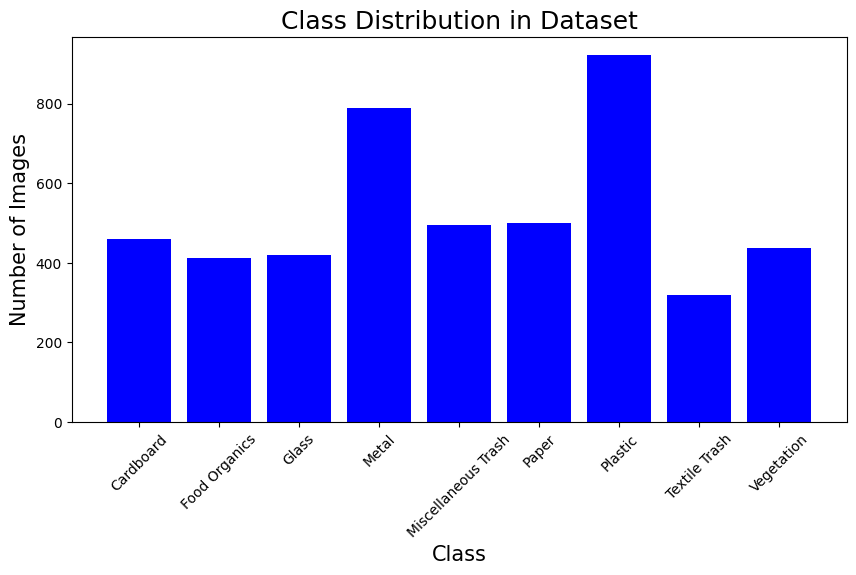

In [14]:


# Count number of images in each class
class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name)))
                for class_name in class_names}

# Plot the class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

In [15]:
# Iterate over batches of the training dataset
train_labels = []

# Use .as_numpy_iterator() to convert the TensorFlow dataset to numpy
for batch in train_dataset.as_numpy_iterator():
    labels = batch[1]  # Extract the labels (second element of the batch)

    # If labels are one-hot encoded, convert to class indices
    if labels.ndim > 1:
        labels = np.argmax(labels, axis=1)  # Convert one-hot to class indices

    train_labels.extend(labels)  # Add the labels to the list

# Convert the list of labels into a numpy array
train_labels = np.array(train_labels)

# Compute class weights based on the training labels
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Print out class weights (for reference)
print("Class weights:", class_weights_dict)


Class weights: {0: np.float64(1.1851851851851851), 1: np.float64(1.3066352571652926), 2: np.float64(1.32536837913182), 3: np.float64(0.6464646464646465), 4: np.float64(1.0271604938271606), 5: np.float64(1.0565079365079366), 6: np.float64(0.5878819996467055), 7: np.float64(1.5735224586288417), 8: np.float64(1.2005772005772006)}


In [16]:

def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal loss for multi-class classification with one-hot labels.
    """
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)

    return loss

In [17]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [24]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model



# Build the model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation="relu"),
    layers.Dense(9, activation="softmax")  # Adjust for the number of classes
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss= categorical_focal_loss(),
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss",  # Monitor the validation loss
                               patience=3,  # Number of epochs to wait for improvement
                               restore_best_weights=True,  # Restore the best model weights when stopping
                               verbose=1)  # Print messages when stopping

history = model.fit(train_dataset, validation_data=val_dataset, epochs=20,  callbacks=[early_stopping])



Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 70s 483ms/step - accuracy: 0.1339 - loss: 0.4769 - val_accuracy: 0.1932 - val_loss: 0.4282
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 420ms/step - accuracy: 0.1598 - loss: 0.4632 - val_accuracy: 0.1477 - val_loss: 0.4296
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 45s 429ms/step - accuracy: 0.1691 - loss: 0.4617 - val_accuracy: 0.1776 - val_loss: 0.4287
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 425ms/step - accuracy: 0.1628 - loss: 0.4541 - val_accuracy: 0.1903 - val_loss: 0.4276
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 423ms/step - accuracy: 0.1609 - loss: 0.4525 - val_accuracy: 0.2074 - val_loss: 0.4279
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 423ms/step - accuracy: 0.1642 - loss: 0.4529 - val_accuracy: 0.1690 - val_loss: 0.4264
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 45s 427ms/step - accuracy: 0.1545 - loss: 0.4545 - val_accuracy: 0.1690 - val_loss: 0.4268
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 45s 428ms/step - accuracy: 0.1627 - loss: 0

In [25]:
# Get true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    preds = model.predict(images)  # Get predicted probabilities
    y_true.extend(labels.numpy())  # Directly extend with integer labels
    y_pred_probs.extend(preds)  # Store predicted probabilities

y_pred_probs = np.array(y_pred_probs)
y_true = np.array(y_true)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

print("True labels shape:", y_true.shape)
print("Predicted labels shape:", y_pred.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
True labels shape: (704, 9)
Predicted labels shape: (704,)


In [28]:

# If predictions are one-hot encoded, convert to class indices
if y_pred.ndim > 1:
    y_pred = np.argmax(y_pred, axis=1)

# Similarly, convert true labels if they are one-hot encoded
if y_true.ndim > 1:
    y_true = np.argmax(y_true, axis=1)

# Print the classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.00      0.00      0.00        65
           2       0.00      0.00      0.00        68
           3       0.02      0.01      0.01       120
           4       0.00      0.00      0.00        69
           5       0.00      0.00      0.00        73
           6       0.21      1.00      0.35       136
           7       0.00      0.00      0.00        39
           8       0.00      0.00      0.00        59

    accuracy                           0.19       704
   macro avg       0.03      0.11      0.04       704
weighted avg       0.04      0.19      0.07       704



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
# Fine-tuning (optional)
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze first 100 layers
    layer.trainable = True

# Recompile after unfreezing
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              loss= categorical_focal_loss(),
              metrics=["accuracy"])

# Train again on the small batch
history_fine_tune = model.fit(train_dataset, validation_data=val_dataset, epochs=30, class_weight=class_weights_dict)

Epoch 1/30


KeyboardInterrupt: 

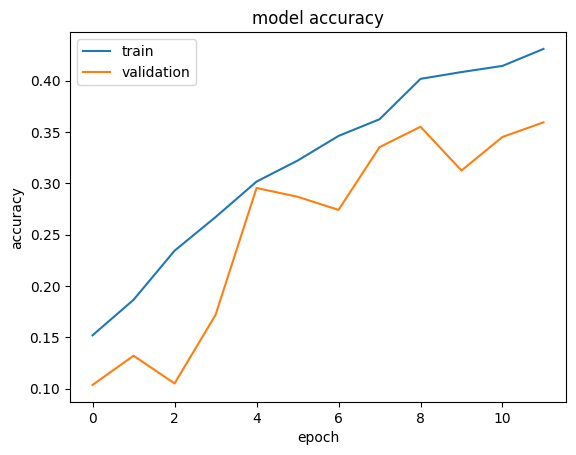

In [30]:
def plot_hist(history_fine_tune):
    plt.plot(history_fine_tune.history["accuracy"])
    plt.plot(history_fine_tune.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history_fine_tune)

In [31]:
# Get true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    preds = model.predict(images)  # Get predicted probabilities
    y_true.extend(labels.numpy())  # Directly extend with integer labels
    y_pred_probs.extend(preds)  # Store predicted probabilities

y_pred_probs = np.array(y_pred_probs)
y_true = np.array(y_true)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

print("True labels shape:", y_true.shape)
print("Predicted labels shape:", y_pred.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
True labels shape: (704, 9)
Predicted labels shape: (704,)


In [33]:

# If predictions are one-hot encoded, convert to class indices
if y_pred.ndim > 1:
    y_pred = np.argmax(y_pred, axis=1)

# Similarly, convert true labels if they are one-hot encoded
if y_true.ndim > 1:
    y_true = np.argmax(y_true, axis=1)

# Print the classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.34      0.58      0.43        79
           1       0.39      0.29      0.33        66
           2       0.44      0.28      0.34        65
           3       0.58      0.45      0.51       117
           4       0.20      0.19      0.19        68
           5       0.29      0.41      0.34        74
           6       0.32      0.21      0.26       126
           7       0.43      0.31      0.36        48
           8       0.46      0.75      0.57        61

    accuracy                           0.38       704
   macro avg       0.38      0.39      0.37       704
weighted avg       0.39      0.38      0.37       704



In [ ]:

# Convert true labels to one-hot encoding
num_classes = 9  # Adjust to your number of classes
y_true_one_hot = to_categorical(y_true, num_classes)

# Plot ROC Curve for each class
plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot baseline
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:



def build_model(hp):
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = hp.Boolean('trainable', default=False)  # Fine-tuning option

    # Fine-tuning option
    trainable = hp.Boolean('trainable', default=False)  # Start with frozen model
    base_model.trainable = trainable

    # Unfreeze the top N layers if trainable
    if trainable:
        num_unfrozen_layers = hp.Int("unfreeze_layers", min_value=10, max_value=30, step=5)
        for layer in base_model.layers[-num_unfrozen_layers:]:
            layer.trainable = True

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(hp.Float("dropout_rate", min_value=0.3, max_value=0.7, step=0.1)),
        layers.Dense(hp.Int("units", min_value=128, max_value=512, step=64), activation="relu"),
        layers.Dense(9, activation="softmax")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", [1e-4, 1e-5, 1e-6])),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [ ]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    directory="hyperparameter_tuning",
    project_name="efficientnet_tuning"
)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

In [ ]:
tuner.search(final_train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping, lr_scheduler])

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Best Learning Rate: {best_hp.get('learning_rate')}")
print(f"Best Dropout Rate: {best_hp.get('dropout_rate')}")
print(f"Best Number of Units: {best_hp.get('units')}")
print(f"Trainable Base Model: {best_hp.get('trainable')}")


In [ ]:
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    final_train_dataset,
    validation_data=val_dataset,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, lr_scheduler]
)


In [ ]:
tuner.results_summary()


In [ ]:
from sklearn.metrics import classification_report

# Get true labels and predicted probabilities
y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    preds = best_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # One-hot to class index
    y_pred_probs.extend(preds)

# Convert to arrays
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Get predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)


In [ ]:


print(classification_report(y_true, y_pred, zero_division=0))


In [ ]:
# Evaluate on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
